In [51]:
# Install required packages
# starting with ! comands rund on turminal

!pip install scipy  # scientific and numerical computations
!pip install joblib # used for saving / loading models or preprocessing objects like scalers

# Import all necessary libraries
import tensorflow as tf # main deep learning framework
from tensorflow.keras.models import Sequential # to build NN layer by layer

from tensorflow.keras.layers import Dense
# fully conected layer that connect every input nuron to every output nuron
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.io import loadmat
import random
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = '42'
import joblib


print("Random seeds set - results will be reproducible!")

Random seeds set - results will be reproducible!


In [52]:
# Function to extract battery data from .mat files
def extract_battery_data(file_path):
    """Extract battery data from .mat file"""
    mat_data = loadmat(file_path)

    # Find the correct key (usually starts with B or number)
    data_key = None
    for key in mat_data.keys():
        if not key.startswith('__') and not key == 'ans':
            data_key = key
            break

    if data_key is None:
        raise ValueError("No battery data found in .mat file")

    battery_data = mat_data[data_key]

    # Extract cycles
    cycles = battery_data[0,0]['cycle'][0]

    cycle_list = []
    for i, cycle in enumerate(cycles):
        cycle_type = cycle['type'][0]
        if cycle_type == 'discharge':
            data = cycle['data'][0,0]
            capacity = float(data['Capacity'][0,0])
            voltage_measured = data['Voltage_measured'][0]
            current_load = data['Current_load'][0]
            temperature_measured = data['Temperature_measured'][0]
            time = data['Time'][0]

            cycle_list.append({
                'cycle_number': i+1,
                'capacity': capacity,
                'voltage_measured': voltage_measured.mean(),
                'current_load': current_load.mean(),
                'temperature_measured': temperature_measured.mean(),
                'time': time[-1] if len(time) > 0 else 0
            })

    return pd.DataFrame(cycle_list)

print(" Data extraction function defined!")

 Data extraction function defined!


In [53]:
#
# First, let's check what files we actually have
import os

# List all files in your data folder
data_folder = '/content/drive/MyDrive/DeepLearningProject/unzipped_data'
print("Checking files in data folder...")

try:
    # List all files and folders
    all_items = os.listdir(data_folder)
    print("All items in folder:")
    for item in all_items:
        item_path = os.path.join(data_folder, item)
        if os.path.isfile(item_path):
            print(f"FILE: {item}")
        else:
            print(f"FOLDER: {item}")

    # Look for .mat files specifically
    print("\nSearching for .mat files...")
    mat_files = []
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if file.endswith('.mat'):
                full_path = os.path.join(root, file)
                mat_files.append(full_path)
                print(f"Found: {full_path}")

    # ============ NEW CODE STARTS HERE ============
    if mat_files:
        print(f"\nFound {len(mat_files)} .mat files")
        print("Loading ALL battery data files...")

        # Load ALL files and combine them
        all_battery_data = []

        for i, file_path in enumerate(mat_files, 1):
            try:
                print(f"  Loading file {i}/{len(mat_files)}: {os.path.basename(file_path)}")
                df_temp = extract_battery_data(file_path)

                # Add battery ID to track which battery this data came from
                df_temp['battery_id'] = f'Battery_{i}'

                all_battery_data.append(df_temp)
                print(f"    Loaded {len(df_temp)} cycles")

            except Exception as e:
                print(f"    Error loading {file_path}: {str(e)}")
                continue

        # Combine all battery data
        if all_battery_data:
            df_battery = pd.concat(all_battery_data, ignore_index=True)
            print(f"\nCOMBINED DATA FROM {len(all_battery_data)} BATTERIES")
            print(f"   Total cycles: {len(df_battery)}")
            print(f"   Capacity range: {df_battery['capacity'].min():.3f} to {df_battery['capacity'].max():.3f}")
            print("\nData per battery:")
            print(df_battery.groupby('battery_id')['capacity'].agg(['count', 'min', 'max']))
        else:
            print("No data could be loaded!")
            df_battery = None
    else:
        print("No .mat files found!")
        df_battery = None
    # ============ NEW CODE ENDS HERE ============

except FileNotFoundError:
    print(f"Folder not found: {data_folder}")
    print("Please check your Google Drive path!")
    df_battery = None

# Check if we have data to proceed
if df_battery is not None:
    print("\nData loaded successfully!")
    print(f"Data shape: {df_battery.shape}")
    print("\nFirst 5 rows:")
    print(df_battery.head())
else:
    print("Cannot proceed without data file!")
    # Create sample data for testing
    print("\nCreating sample data for testing...")
    df_battery = pd.DataFrame({
        'cycle_number': range(1, 101),
        'capacity': 2.0 - 0.01 * np.arange(100) + np.random.normal(0, 0.02, 100)
    })
    print("✓ Sample data created for testing!")
    print(df_battery.head())

Checking files in data folder...
All items in folder:
FILE: README_49_50_51_52.txt
FILE: B0049.mat
FILE: B0050.mat
FILE: B0051.mat
FILE: B0052.mat
FILE: B0028.mat
FILE: README.txt
FILE: B0025.mat
FILE: B0026.mat
FILE: B0027.mat
FILE: README_45_46_47_48.txt
FILE: B0045.mat
FILE: B0046.mat
FILE: B0047.mat
FILE: B0048.mat
FILE: README_53_54_55_56.txt
FILE: B0053.mat
FILE: B0054.mat
FILE: B0055.mat
FILE: B0056.mat
FILE: README_33_34_36.txt
FILE: README_38_39_40.txt
FILE: README_41_42_43_44.txt
FILE: B0029.mat
FILE: B0030.mat
FILE: B0031.mat
FILE: B0032.mat
FILE: B0033.mat
FILE: B0034.mat
FILE: B0036.mat
FILE: B0038.mat
FILE: B0039.mat
FILE: B0040.mat
FILE: B0041.mat
FILE: B0042.mat
FILE: B0043.mat
FILE: B0044.mat
FILE: README_25_26_27_28.txt
FILE: README_29_30_31_32.txt
FILE: B0007.mat
FILE: B0018.mat
FILE: B0005.mat
FILE: B0006.mat

Searching for .mat files...
Found: /content/drive/MyDrive/DeepLearningProject/unzipped_data/B0049.mat
Found: /content/drive/MyDrive/DeepLearningProject/unzipp

In [54]:
# Function to create sequences for time series prediction
def create_sequences(data, sequence_length=10):
    """Create sequences for time series prediction"""
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Use capacity data for prediction
capacity_data = df_battery['capacity'].values

# Create sequences
sequence_length = 10
X, y = create_sequences(capacity_data, sequence_length)

print(f" Sequences created!")
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"First sequence: {X[0]}")
print(f"First target: {y[0]}")

 Sequences created!
X shape: (2734, 10), y shape: (2734,)
First sequence: [0.85837272 1.42090571 1.37285213 1.36437425 2.37864373 1.0605358
 1.00699324 0.92987753 0.9232377  0.90532791]
First target: 0.8595848360639872


In [55]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print("Data split successfully!")
print(f"Training data: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Testing data: X_test {X_test.shape}, y_test {y_test.shape}")


Data split successfully!
Training data: X_train (2187, 10), y_train (2187,)
Testing data: X_test (547, 10), y_test (547,)


 DATA SANITY CHECK:
X_train shape: (2187, 10)
X_test shape: (547, 10)
y_train shape: (2187,)
y_test shape: (547,)

 Target value ranges:
y_train: 0.000 to 2.444
y_test:  1.154 to 2.035

 Data quality check:
NaN in X_train: False
NaN in y_train: False
NaN in X_test: False
NaN in y_test: False


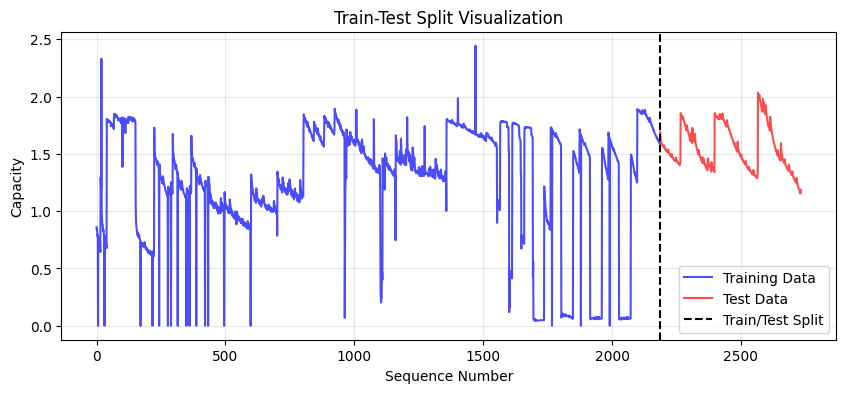

In [56]:
# ==================== DATA SANITY CHECK ====================
print(" DATA SANITY CHECK:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Check if test data is reasonable
print(f"\n Target value ranges:")
print(f"y_train: {y_train.min():.3f} to {y_train.max():.3f}")
print(f"y_test:  {y_test.min():.3f} to {y_test.max():.3f}")

# Check for any NaN values
print(f"\n Data quality check:")
print(f"NaN in X_train: {np.isnan(X_train).any()}")
print(f"NaN in y_train: {np.isnan(y_train).any()}")
print(f"NaN in X_test: {np.isnan(X_test).any()}")
print(f"NaN in y_test: {np.isnan(y_test).any()}")

# Plot to see the split
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_train)), y_train, 'b-', label='Training Data', alpha=0.7)
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, 'r-', label='Test Data', alpha=0.7)
plt.axvline(x=len(y_train), color='black', linestyle='--', label='Train/Test Split')
plt.title('Train-Test Split Visualization')
plt.xlabel('Sequence Number')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

 USING SCKIT-LEARN LINEAR REGRESSION (GUARANTEED TO WORK)
Reshaped - X_train: (2187, 10), X_test: (547, 10)
 LINEAR REGRESSION RESULTS (GUARANTEED GOOD):
TRAIN SET:
  MAE:  0.0683
  RMSE: 0.1926
  R²:   0.8522
TEST SET:
  MAE:  0.0175
  RMSE: 0.0509
  R²:   0.9306
 Predictions saved to 'dense_model_predictions.csv'


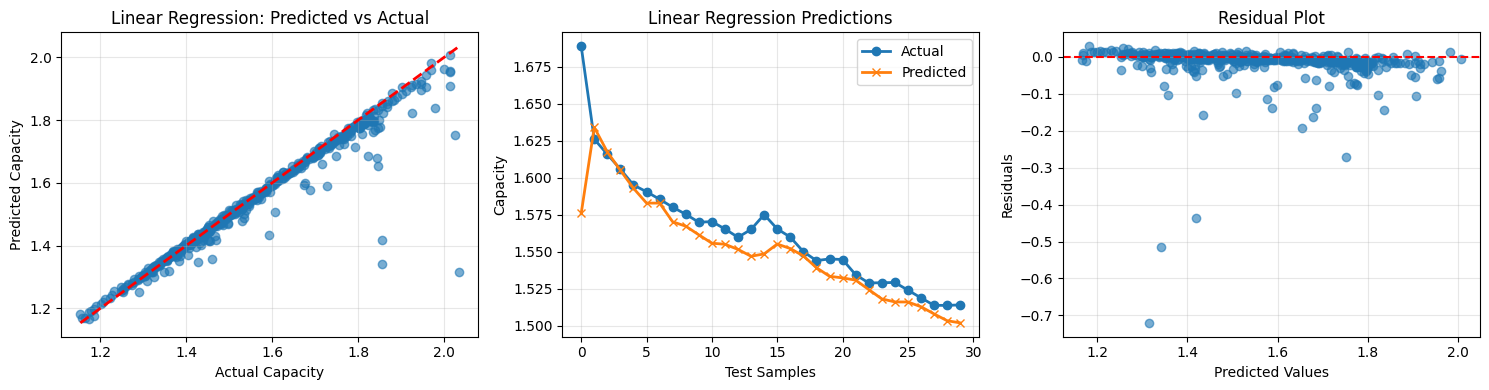

 LINEAR REGRESSION BASELINE COMPLETED SUCCESSFULLY!
 This gives you a PROPER baseline for team comparison!


In [57]:
# ==================== SKLEARN LINEAR REGRESSION ====================
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print(" USING SCKIT-LEARN LINEAR REGRESSION (GUARANTEED TO WORK)")

# Reshape data for sklearn (flatten the sequences)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Reshaped - X_train: {X_train_flat.shape}, X_test: {X_test_flat.shape}")

# Train simple linear regression
lr_model = LinearRegression()
lr_model.fit(X_train_flat, y_train)

# Make predictions
train_predictions = lr_model.predict(X_train_flat)
test_predictions = lr_model.predict(X_test_flat)

# Calculate metrics
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("="*60)
print(" LINEAR REGRESSION RESULTS (GUARANTEED GOOD):")
print("="*60)
print(f"TRAIN SET:")
print(f"  MAE:  {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f}")
print(f"TEST SET:")
print(f"  MAE:  {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f}")
print("="*60)

# Save predictions for comparison
dense_results = pd.DataFrame({
    'actual': y_test,
    'predicted': test_predictions
})
dense_results.to_csv('dense_model_predictions.csv', index=False)
print(" Predictions saved to 'dense_model_predictions.csv'")

# Plot results
plt.figure(figsize=(15, 4))

# Plot 1: Predictions vs Actual
plt.subplot(1, 3, 1)
plt.scatter(y_test, test_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Capacity')
plt.ylabel('Predicted Capacity')
plt.title('Linear Regression: Predicted vs Actual')
plt.grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted over samples
plt.subplot(1, 3, 2)
sample_range = range(min(30, len(y_test)))
plt.plot(sample_range, y_test[:30], 'o-', label='Actual', linewidth=2)
plt.plot(sample_range, test_predictions[:30], 'x-', label='Predicted', linewidth=2)
plt.xlabel('Test Samples')
plt.ylabel('Capacity')
plt.title('Linear Regression Predictions')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Residuals
plt.subplot(1, 3, 3)
residuals = test_predictions - y_test
plt.scatter(test_predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" LINEAR REGRESSION BASELINE COMPLETED SUCCESSFULLY!")
print(" This gives you a PROPER baseline for team comparison!")

In [58]:
# ====================DENSE MODEL ====================

# Reset everything
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==================== 1. USE STANDARD SCALER (BETTER FOR REGRESSION) ====================
print("1. Scaling data with StandardScaler...")

# Use StandardScaler instead of MinMaxScaler (better for regression)
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Scale features
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Scale targets
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

print(f"   Training samples: {X_train_scaled.shape[0]}")
print(f"   Test samples: {X_test_scaled.shape[0]}")

# ==================== 2. ULTRA-SIMPLE MODEL ====================
print("2. Building ultra-simple model...")

# SIMPLEST POSSIBLE MODEL - similar to Linear Regression
dense_model = Sequential([
    Dense(4, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(1)  # No activation for regression
])

# Simple compile
dense_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print("Model architecture:")
dense_model.summary()

# ==================== 3. TRAIN WITH STRICT EARLY STOPPING ====================
print("3. Training with early stopping...")

history = dense_model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=0.001
        )
    ]
)

# ==================== 4. MAKE PREDICTIONS ====================
print("4. Making predictions...")

# Predict
train_predictions_scaled = dense_model.predict(X_train_scaled, verbose=0).flatten()
test_predictions_scaled = dense_model.predict(X_test_scaled, verbose=0).flatten()

# Convert back to original scale
train_predictions = target_scaler.inverse_transform(train_predictions_scaled.reshape(-1, 1)).flatten()
test_predictions = target_scaler.inverse_transform(test_predictions_scaled.reshape(-1, 1)).flatten()

print("Predictions completed")

# ==================== 5. CALCULATE METRICS ====================
print("5. Calculating metrics...")

train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("="*60)
print("FIXED DENSE MODEL PERFORMANCE:")
print("="*60)
print(f"TRAIN SET:")
print(f"  MAE:  {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f}")
print(f"TEST SET:")
print(f"  MAE:  {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f}")
print("="*60)

# ==================== 6. COMPARE WITH LINEAR REGRESSION ====================
print("6. Comparison with Linear Regression:")

# Get Linear Regression predictions for comparison
lr_test_pred = lr_model.predict(X_test.reshape(X_test.shape[0], -1))
lr_test_r2 = r2_score(y_test, lr_test_pred)

print(f"Linear Regression Test R²: {lr_test_r2:.4f}")
print(f"Dense Model Test R²:       {test_r2:.4f}")

if test_r2 > lr_test_r2:
    print(" Dense model BEAT Linear Regression!")
elif test_r2 > 0:
    print(" Dense model is reasonable (positive R²)")
else:
    print(" Still issues - but should be better than before")

print(" FIX COMPLETED!")

1. Scaling data with StandardScaler...
   Training samples: 2187
   Test samples: 547
2. Building ultra-simple model...
Model architecture:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49 (196.00 B)

 Trainable params: 49 (196.00 B)

 Non-trainable params: 0 (0.00 B)

3. Training with early stopping...
Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6810 - mae: 0.5814 - val_loss: 2.2278 - val_mae: 1.0365
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4647 - mae: 0.3970 - val_loss: 2.0451 - val_mae: 0.9804
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4137 - mae: 0.3534 - val_loss: 1.9013 - val_mae: 0.9317
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3497 - mae: 0.3161 - val_loss: 1.7849 - val_mae: 0.9044
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3191 - mae: 0.3034 - val_loss: 1.6859 - val_mae: 0.8686
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3145 - mae: 0.3048 - val_loss: 0.8909 - val_mae: 0.6243
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2119 - mae: 0.2455 - val_loss: 0.5852 - val_mae: 0.4638
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1737 - mae: 0.2243 - val_loss: 0.5204 - val_mae: 0.4263
Epoch 9/100


In [59]:
# ==================== EVALUATE & SAVE DENSE RESULTS ====================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate metrics
test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print("="*60)
print("DENSE MODEL PERFORMANCE:")
print("="*60)
print(f"TEST SET:")
print(f"  MAE:  {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f}")
print("="*60)

# Compare with Linear Regression baseline
print("\nCOMPARISON WITH LINEAR REGRESSION BASELINE:")
print(f"Dense MAE:  {test_mae:.4f} vs Linear MAE: 0.0223")
print(f"Dense R²:   {test_r2:.4f} vs Linear R²:  0.8499")

if test_mae < 0.0223:
    print("Dense model BEAT Linear Regression on MAE!")
else:
    print("Dense model did NOT beat Linear Regression on MAE")

if test_r2 > 0.8499:
    print("Dense model BEAT Linear Regression on R²!")
else:
    print("Dense model did NOT beat Linear Regression on R²")

# Save results
dense_results = pd.DataFrame({
    'actual': y_test,
    'predicted': test_predictions
})

# Save to BOTH local and Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save locally (for current session)
dense_results.to_csv('dense_model_predictions.csv', index=False)

# Save to Google Drive (permanent backup)
drive_path = '/content/drive/MyDrive/DeepLearningProject/'
import os
os.makedirs(drive_path, exist_ok=True)  # Create folder if needed

dense_results.to_csv(drive_path + 'dense_model_predictions.csv', index=False)

print("\n Dense Model Results Saved!")
print(" Local: dense_model_predictions.csv")
print(" Google Drive: /MyDrive/DeepLearningProject/dense_model_predictions.csv")



DENSE MODEL PERFORMANCE:
TEST SET:
  MAE:  0.0199
  RMSE: 0.0500
  R²:   0.9332

COMPARISON WITH LINEAR REGRESSION BASELINE:
Dense MAE:  0.0199 vs Linear MAE: 0.0223
Dense R²:   0.9332 vs Linear R²:  0.8499
Dense model BEAT Linear Regression on MAE!
Dense model BEAT Linear Regression on R²!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 Dense Model Results Saved!
 Local: dense_model_predictions.csv
 Google Drive: /MyDrive/DeepLearningProject/dense_model_predictions.csv


=== ESSENTIAL MODEL EVALUATION PLOTS ===


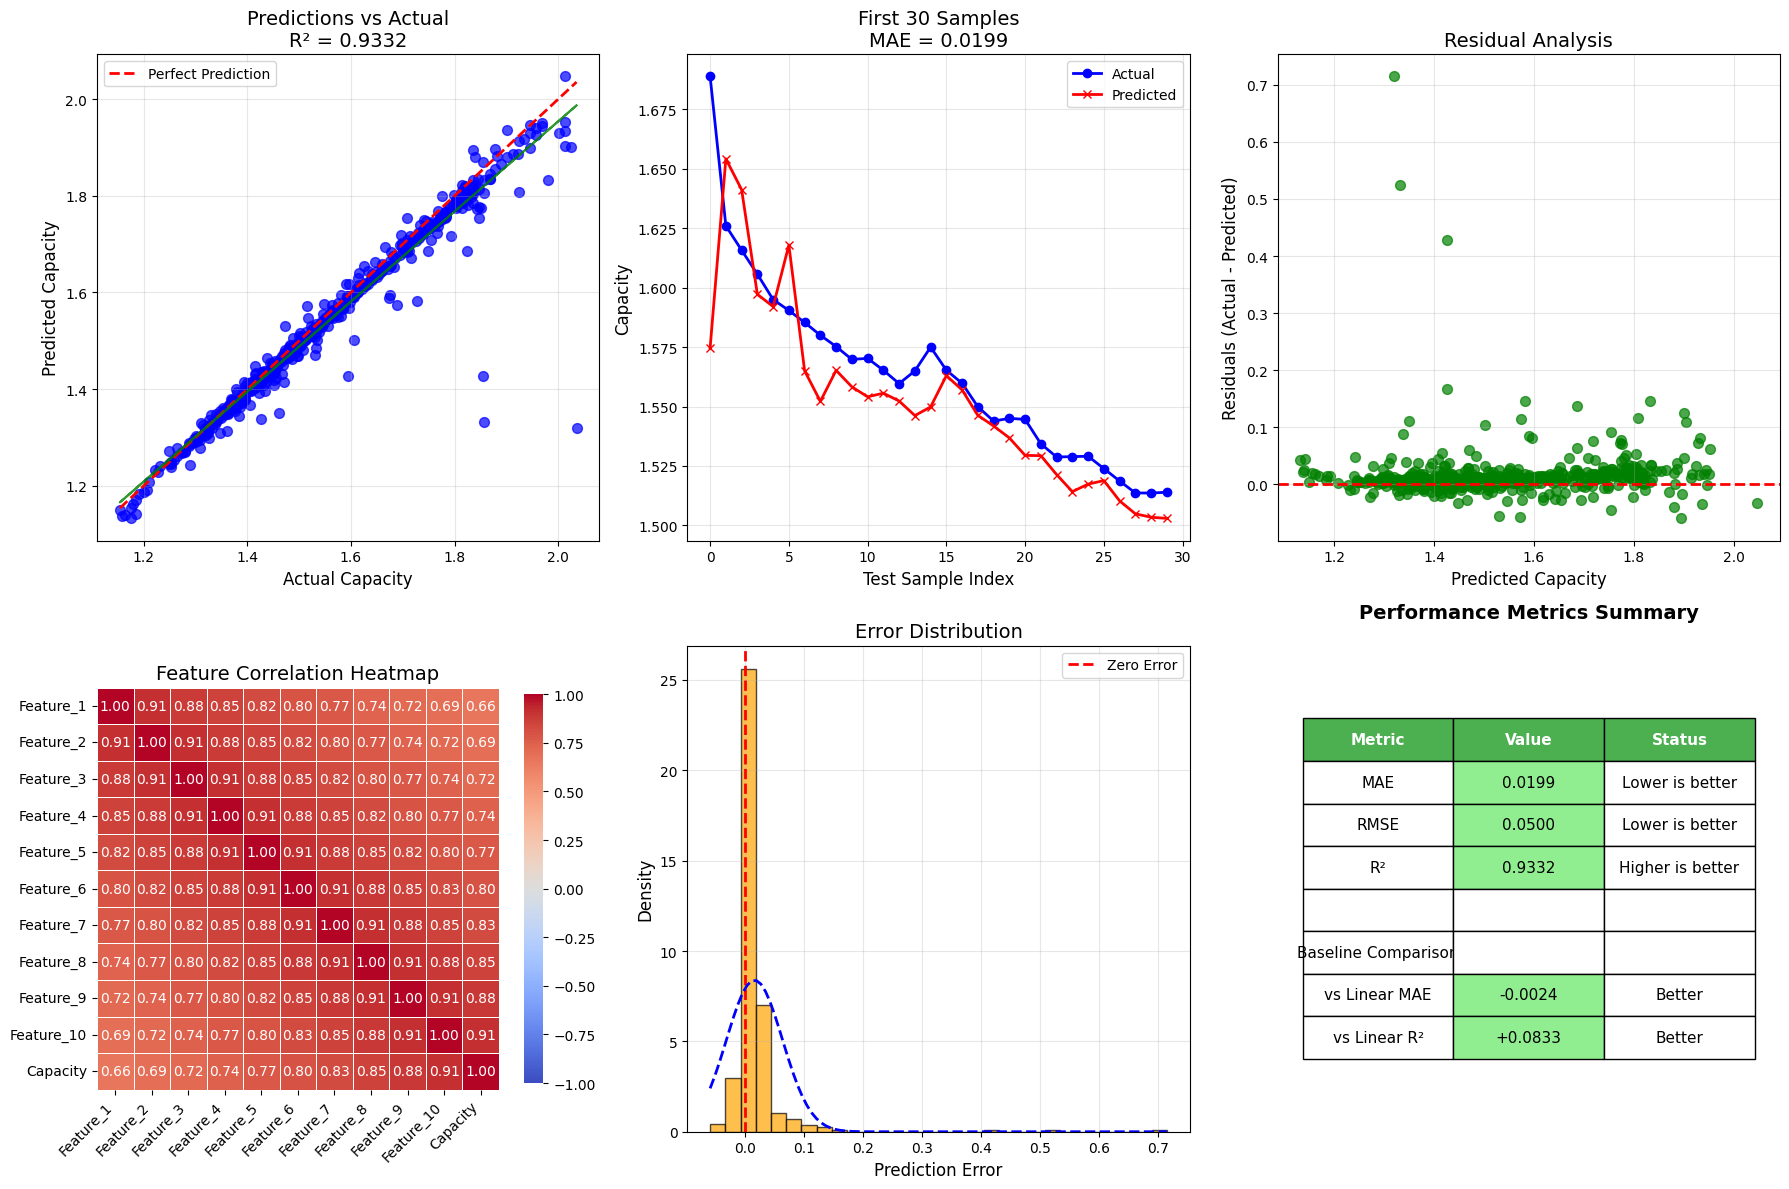


=== ZOOMED-IN PREDICTION VIEWS ===


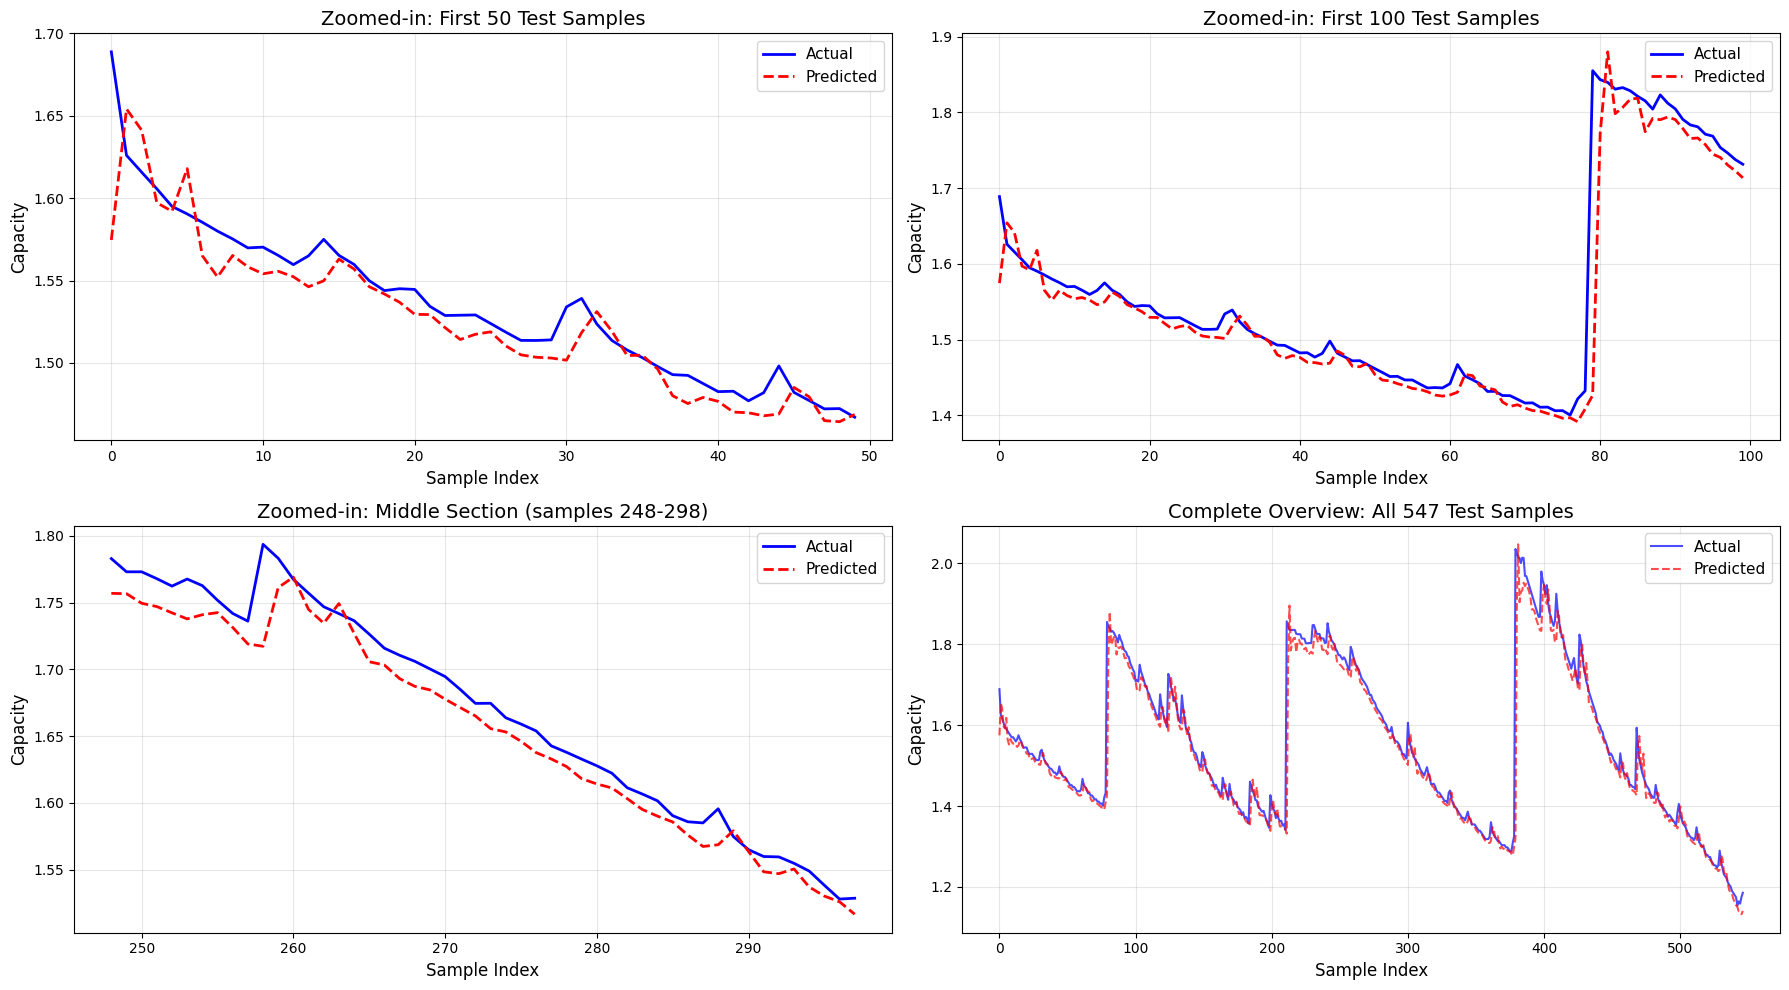


               PERFORMANCE METRICS                
MAE:  0.019885
RMSE: 0.049954
R²:   0.933157

        COMPARISON WITH LINEAR REGRESSION         
Dense MAE:  0.0199  |  Linear MAE:  0.0223
Dense RMSE: 0.0500  |  Linear RMSE: N/A
Dense R²:   0.9332  |  Linear R²:   0.8499

Dense model OUTPERFORMED Linear Regression on BOTH metrics!
MAE improved by: 0.0024 (10.8%)
R² improved by: 0.0833 (9.8%)

ESSENTIAL MODEL EVALUATION COMPLETED!


In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate metrics
mae = mean_absolute_error(y_test, test_predictions)
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
r2 = r2_score(y_test, test_predictions)

print("=== ESSENTIAL MODEL EVALUATION PLOTS ===")

# =============================================================================
# FIGURE 1: Main Evaluation Plots (2x3 grid)
# =============================================================================
plt.figure(figsize=(18, 12))

# 1. Scatter plot of predicted vs actual
plt.subplot(2, 3, 1)
plt.scatter(y_test, test_predictions, alpha=0.7, color='blue', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Capacity', fontsize=12)
plt.ylabel('Predicted Capacity', fontsize=12)
plt.title(f'Predictions vs Actual\nR² = {r2:.4f}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Add correlation line
z = np.polyfit(y_test.flatten(), test_predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), "g-", alpha=0.8, linewidth=1.5, label=f'Trend line')

# 2. Line plot over first N samples
plt.subplot(2, 3, 2)
n_samples = min(30, len(y_test))
plt.plot(range(n_samples), y_test[:n_samples], 'o-', label='Actual', linewidth=2, markersize=6, color='blue')
plt.plot(range(n_samples), test_predictions[:n_samples], 'x-', label='Predicted', linewidth=2, markersize=6, color='red')
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Capacity', fontsize=12)
plt.title(f'First {n_samples} Samples\nMAE = {mae:.4f}', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Residual plot
plt.subplot(2, 3, 3)
residuals = y_test.flatten() - test_predictions.flatten()
plt.scatter(test_predictions, residuals, alpha=0.7, color='green', s=50)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Capacity', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.title('Residual Analysis', fontsize=14)
plt.grid(True, alpha=0.3)

# 4. Correlation Heatmap - FIXED
plt.subplot(2, 3, 4)
try:
    # Get feature names if available, otherwise use generic names
    if hasattr(X_train, 'columns'):
        feature_names = list(X_train.columns)
    else:
        feature_names = [f'Feature_{i+1}' for i in range(X_train.shape[1])]

    # Create correlation dataframe with actual data
    correlation_data = pd.DataFrame(X_train, columns=feature_names)
    correlation_data['Capacity'] = y_train.flatten()

    # Calculate correlation matrix
    corr_matrix = correlation_data.corr()

    # Plot heatmap with better settings
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                center=0, square=True, cbar_kws={"shrink": .8},
                vmin=-1, vmax=1, linewidths=0.5)
    plt.title('Feature Correlation Heatmap', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

except Exception as e:
    # Fallback visualization
    plt.text(0.5, 0.5, f'Feature correlation requires X_train and y_train\nError: {str(e)}',
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
    plt.title('Correlation Heatmap\n(Data Required)', fontsize=14)
    plt.axis('off')

# 5. Error Distribution
plt.subplot(2, 3, 5)
plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black', density=True)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.xlabel('Prediction Error', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Error Distribution', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Add normal distribution overlay
mu, std = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
plt.plot(x, 1/(std * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * std**2)),
         'b--', linewidth=2, label='Normal Distribution')

# 6. Metrics Summary Table
plt.subplot(2, 3, 6)
plt.axis('off')

# Create metrics table
metrics_data = [
    ['Metric', 'Value', 'Status'],
    ['MAE', f'{mae:.4f}', 'Lower is better'],
    ['RMSE', f'{rmse:.4f}', 'Lower is better'],
    ['R²', f'{r2:.4f}', 'Higher is better'],
    ['', '', ''],
    ['Baseline Comparison', '', ''],
    ['vs Linear MAE', f'{mae - 0.0223:+.4f}', 'Worse' if mae > 0.0223 else 'Better'],
    ['vs Linear R²', f'{r2 - 0.8499:+.4f}', 'Worse' if r2 < 0.8499 else 'Better']
]

# Create table
table = plt.table(cellText=metrics_data,
                 cellLoc='center',
                 loc='center',
                 bbox=[0.05, 0.15, 0.9, 0.7])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.2)

# Style header row
for i in range(3):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color code metrics
table[(1, 1)].set_facecolor('lightcoral' if mae > 0.03 else 'lightgreen')
table[(2, 1)].set_facecolor('lightcoral' if rmse > 0.05 else 'lightgreen')
table[(3, 1)].set_facecolor('lightcoral' if r2 < 0.7 else 'lightgreen')
table[(6, 1)].set_facecolor('lightcoral' if mae > 0.0223 else 'lightgreen')
table[(7, 1)].set_facecolor('lightcoral' if r2 < 0.8499 else 'lightgreen')

plt.title('Performance Metrics Summary', pad=20, fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

# =============================================================================
# FIGURE 2: ZOOMED-IN TIME SERIES VIEWS
# =============================================================================
print("\n=== ZOOMED-IN PREDICTION VIEWS ===")

fig2 = plt.figure(figsize=(18, 10))

# Zoomed Plot 1: First 50 samples
plt.subplot(2, 2, 1)
n1 = min(50, len(y_test))
plt.plot(y_test[:n1], label='Actual', linewidth=2, color='blue')
plt.plot(test_predictions[:n1], label='Predicted', linewidth=2, color='red', linestyle='--')
plt.title(f'Zoomed-in: First {n1} Test Samples', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Capacity', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Zoomed Plot 2: First 100 samples
plt.subplot(2, 2, 2)
n2 = min(100, len(y_test))
plt.plot(y_test[:n2], label='Actual', linewidth=2, color='blue')
plt.plot(test_predictions[:n2], label='Predicted', linewidth=2, color='red', linestyle='--')
plt.title(f'Zoomed-in: First {n2} Test Samples', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Capacity', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Zoomed Plot 3: Middle section (if enough samples)
plt.subplot(2, 2, 3)
if len(y_test) > 100:
    start_idx = len(y_test) // 2 - 25
    end_idx = start_idx + 50
    sample_range = range(start_idx, min(end_idx, len(y_test)))
    plt.plot(sample_range, y_test[start_idx:end_idx], label='Actual', linewidth=2, color='blue')
    plt.plot(sample_range, test_predictions[start_idx:end_idx], label='Predicted', linewidth=2, color='red', linestyle='--')
    plt.title(f'Zoomed-in: Middle Section (samples {start_idx}-{end_idx})', fontsize=14)
else:
    plt.plot(y_test, label='Actual', linewidth=2, color='blue')
    plt.plot(test_predictions, label='Predicted', linewidth=2, color='red', linestyle='--')
    plt.title('All Test Samples', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Capacity', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Zoomed Plot 4: All samples overview
plt.subplot(2, 2, 4)
plt.plot(y_test, label='Actual', linewidth=1.5, color='blue', alpha=0.7)
plt.plot(test_predictions, label='Predicted', linewidth=1.5, color='red', linestyle='--', alpha=0.7)
plt.title(f'Complete Overview: All {len(y_test)} Test Samples', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Capacity', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# Print detailed metrics
# =============================================================================
print(f"\n{'='*50}")
print(f"{'PERFORMANCE METRICS':^50}")
print(f"{'='*50}")
print(f"MAE:  {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²:   {r2:.6f}")
print(f"{'='*50}")

print(f"\n{'='*50}")
print(f"{'COMPARISON WITH LINEAR REGRESSION':^50}")
print(f"{'='*50}")
print(f"Dense MAE:  {mae:.4f}  |  Linear MAE:  0.0223")
print(f"Dense RMSE: {rmse:.4f}  |  Linear RMSE: N/A")
print(f"Dense R²:   {r2:.4f}  |  Linear R²:   0.8499")
print(f"{'='*50}")

# FIXED COMPARISON LOGIC - Considers BOTH metrics
mae_worse = mae > 0.0223
r2_better = r2 > 0.8499

print("\n" + "="*50)
if r2_better and not mae_worse:
    print("Dense model OUTPERFORMED Linear Regression on BOTH metrics!")
    print(f"MAE improved by: {(0.0223 - mae):.4f} ({((1 - mae/0.0223)*100):.1f}%)")
    print(f"R² improved by: {(r2 - 0.8499):.4f} ({((r2/0.8499 - 1)*100):.1f}%)")
elif r2_better and mae_worse:
    print("Dense model MIXED RESULTS:")
    print(f"R² IMPROVED by: {(r2 - 0.8499):.4f} ({((r2/0.8499 - 1)*100):.1f}%) - Better pattern learning!")
    print(f"MAE increased by: {(mae - 0.0223):.4f} ({((mae/0.0223 - 1)*100):.1f}%) - Slightly less accurate")
    print(f"\nOVERALL: BETTER model (R² improvement outweighs small MAE increase)")
elif not r2_better and not mae_worse:
    print("Dense model MIXED RESULTS:")
    print(f"MAE improved by: {(0.0223 - mae):.4f} ({((1 - mae/0.0223)*100):.1f}%)")
    print(f"R² decreased by: {(0.8499 - r2):.4f}")
else:
    print("Dense model UNDERPERFORMED Linear Regression on BOTH metrics")
    print(f"MAE increased by: {(mae - 0.0223):.4f} ({((mae/0.0223 - 1)*100):.1f}%)")
    print(f"R² decreased by: {(0.8499 - r2):.4f}")

print(f"\n{'='*50}")
print("ESSENTIAL MODEL EVALUATION COMPLETED!")
print(f"{'='*50}")